# **POLI170A Project**

Research question: Does increased availability of on-sale alcohol, specifically Type 41 (On-Sale Beer and Wine – Public) and Type 47 (On-Sale General – Eating), lead to higher rates of crime, such as assault or robbery, in communities in San Diego County?

# Setup

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.stats.outliers_influence import variance_inflation_factor


def decision(pvalue, alpha):
    if pvalue < alpha:
        print(f'reject H0: pvalue={pvalue} < {alpha}')  
    else: 
        print(f'fail to reject H0: pvalue={pvalue} ≥ {alpha}')

def standardize(X):
    return (X - X.mean()) / X.std()

In [2]:
zipcode_df = pd.read_csv("zipcode.csv", header = None)
zipcode_arr = zipcode_df[0].values

# Alcohol Dataset

Records of alcohol licenses in california, from the CA ABC daily file, with improvements to geographic identifiers, and acompilation of areal densities of on-sale and off-sale licenses in San Diego county.

* ca_abc_licenses. California Alcohol Beverage Control License records
* sd_abc_density. Areal density of on-sale and off-sale licenses in San Diego county

In [3]:
# most update dataset from website
ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)

/tmp/ipykernel_4158/735577973.py:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ca_licenses =  pd.read_csv("ABC_WeeklyDataExport.csv", skiprows=1)


In [4]:
sd_abc_density_df =  pd.read_csv('http://library.metatab.org/abc.ca.gov-licenses-2.1.2/data/sd_abc_density.csv')

Briefly browse dataset

In [5]:
ca_licenses.head(3)

,License Type,File Number,Lic or App,Type Status,Type Orig Iss Date,Expir Date,Fee Codes,Dup Counts,Master Ind,Term in # of Months,...,Prem State,Prem Zip,DBA Name,Mail Addr 1,Mail Addr 2,Mail City,Mail State,Mail Zip,Prem County,Prem Census Tract #
0,77,561256,LIC,ACTIVE,01-DEC-2015,30-NOV-2024,P40,001,N,12,...,CA,91762-3644,FIREWATER BAR,,,,,,SAN BERNARDINO,0010.02
1,48,526584,LIC,ACTIVE,08-JAN-2013,31-DEC-2024,P40,001,N,12,...,CA,94578-2815,CLUB CALIENTE,PO BOX 3541,,SAN LEANDRO,CA,94578-0541,ALAMEDA,4331.03
2,77,518989,LIC,ACTIVE,21-JUN-2012,31-MAY-2024,P40,001,N,12,...,CA,93001-2826,BARRELHOUSE 101,,,,,,VENTURA,0024.00


In [6]:
ca_licenses.columns

Index(['License Type', 'File Number', 'Lic or App', 'Type Status',
       'Type Orig Iss Date', 'Expir Date', 'Fee Codes', 'Dup Counts',
       'Master Ind', 'Term in # of Months', 'Geo Code', 'District',
       'Primary Name', 'Prem Addr 1', ' Prem Addr 2', 'Prem City',
       ' Prem State', 'Prem Zip', 'DBA Name', 'Mail Addr 1', 'Mail Addr 2',
       'Mail City', 'Mail State', 'Mail Zip', 'Prem County',
       'Prem Census Tract #'],
      dtype='object')

### Data Cleaning

1. dealing with license issue date, expire date

In [7]:
# drop rows with NaN values in 'Type Orig Iss Date' and 'Expir Date'
ca_licenses['Type Orig Iss Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses['Expir Date'].replace(['', ' '], np.nan, inplace=True)
ca_licenses.dropna(subset=['Type Orig Iss Date', 'Expir Date'], inplace=True)

# convert to datatime
ca_licenses['Type Orig Iss Date'] = pd.to_datetime(ca_licenses['Type Orig Iss Date'], format='%d-%b-%Y')
ca_licenses['Expir Date'] = pd.to_datetime(ca_licenses['Expir Date'], format='%d-%b-%Y')

2. transform all zipcode into 5-digits format

In [8]:
ca_licenses['Prem Zip'] = ca_licenses['Prem Zip'].str.slice(0, 5)

3. filter the dataframe based on the following conditions:
  * Is an active License (Lic) not an Application (App) that is still being processed
  * issue date before 2016-01-01
  * expire date after 2020-07-31
  * license is active
  * license type is 41, 47, or **48**?
  (41; On-Sale Beer and Wine – Public, 47: On-Sale General – Eating, 48: On-Sale General — Public ( Bars and Nightclubs ))
  * license is used within San Diego

In [9]:
df_alcohol = ca_licenses[
    (ca_licenses['Lic or App'] == 'LIC') &
    (ca_licenses['Type Orig Iss Date'] < '2016-01-01') &
    (ca_licenses['Expir Date'] > '2020-07-31') &
    (ca_licenses['Type Status'] == 'ACTIVE') &
    ((ca_licenses['License Type'] == 47) | (ca_licenses['License Type'] == 41)) &
    (ca_licenses['Prem County'] == "SAN DIEGO")
].reset_index(drop = True)

4. select important features <br>
**undecided keep which**

In [10]:
sub_alcohol = df_alcohol[['Type Orig Iss Date', 'Expir Date', 'DBA Name', 'Prem Addr 1', 'Prem City', 'Prem Zip']]
sub_alcohol.head(5)

,Type Orig Iss Date,Expir Date,DBA Name,Prem Addr 1,Prem City,Prem Zip
0,2013-01-16,2024-12-31,LAUBERGE DEL MAR,1540 CAMINO DEL MAR,DEL MAR,92014
1,1993-12-31,2024-11-30,CATAMARAN RESORT HOTEL,3999 MISSION BLVD,SAN DIEGO,92109
2,2012-01-12,2024-12-31,MANCHESTER GRAND HYATT SAN DIEGO,ONE MARKET PLACE,SAN DIEGO,92101
3,2012-01-19,2024-12-31,BARLEY MASH,600 5TH AVE,SAN DIEGO,92101
4,2012-11-30,2024-12-31,BEAUDEVIN,3707 N HARBOR DR,SAN DIEGO,92101


In [11]:
sub_alcohol.shape

(1500, 6)

### EDA

Count the number of licenses based on cities in San Diego

In [12]:
sub_alcohol['Prem City'].unique()

array(['DEL MAR', 'SAN DIEGO', 'LA MESA', 'ESCONDIDO', 'RAMONA', 'POWAY',
       'CARLSBAD', 'LA JOLLA', 'ENCINITAS', 'SANTEE', 'OCEANSIDE',
       'EL CAJON', 'SOLANA BEACH', 'SAN MARCOS', 'VISTA', 'PAUMA VALLEY',
       'IMPERIAL BEACH', 'NATIONAL CITY', 'BONSALL', 'CORONADO',
       'CHULA VISTA', 'LAKESIDE', 'BORREGO SPRINGS', 'JAMUL', 'FALLBROOK',
       'PALA', 'PALOMAR MOUNTAIN', 'BONITA', 'ALPINE', 'SAN YSIDRO',
       'CARDIFF BY THE SEA', 'SPRING VALLEY', 'VALLEY CENTER', 'CAMPO',
       'LEMON GROVE', 'RANCHO SANTA FE', 'DULZURA', 'DESCANSO', 'JULIAN'],
      dtype=object)

In [13]:
nlicense = sub_alcohol.groupby('Prem City')['DBA Name'].count().sort_values(ascending = False)
nlicense

Prem City
SAN DIEGO             769
CHULA VISTA            70
CARLSBAD               62
OCEANSIDE              61
LA JOLLA               59
ESCONDIDO              55
EL CAJON               42
LA MESA                41
SAN MARCOS             39
ENCINITAS              38
CORONADO               31
VISTA                  29
SOLANA BEACH           25
SANTEE                 21
NATIONAL CITY          18
POWAY                  17
DEL MAR                15
RAMONA                 14
FALLBROOK              14
ALPINE                 10
BORREGO SPRINGS         8
LAKESIDE                8
IMPERIAL BEACH          7
BONITA                  6
RANCHO SANTA FE         6
VALLEY CENTER           6
SPRING VALLEY           5
BONSALL                 5
LEMON GROVE             4
PAUMA VALLEY            3
PALA                    2
CARDIFF BY THE SEA      2
JAMUL                   2
PALOMAR MOUNTAIN        1
DESCANSO                1
SAN YSIDRO              1
CAMPO                   1
JULIAN                  1
DU

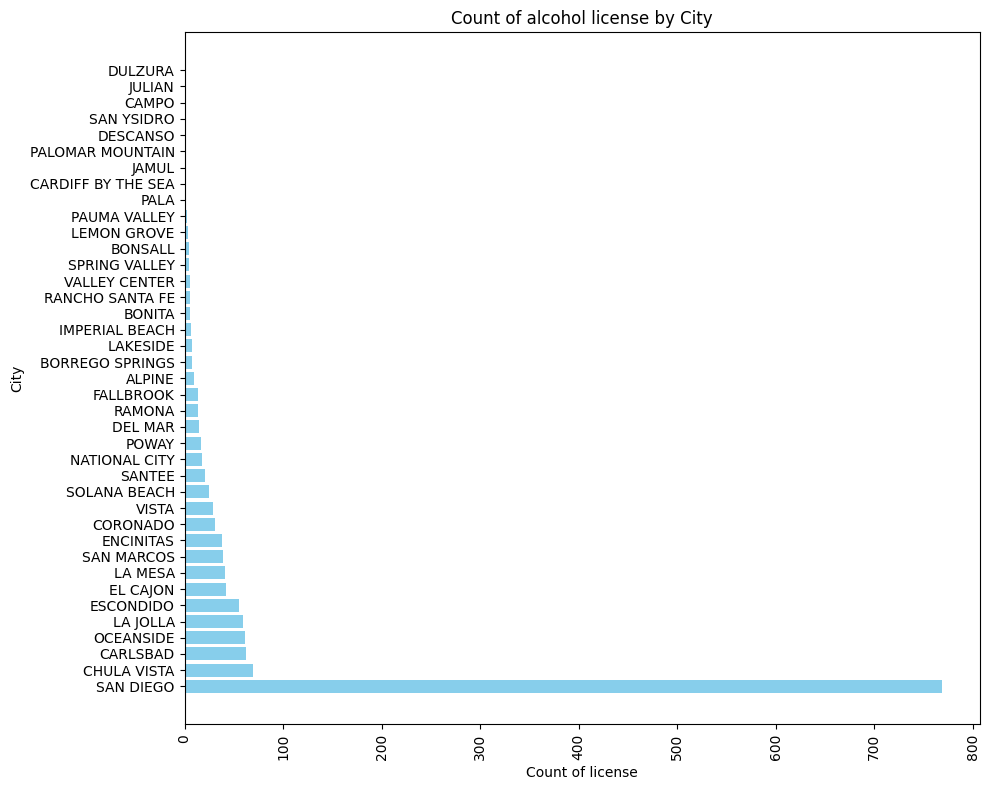

In [14]:
plt.figure(figsize=(10, 8))
plt.barh(nlicense.index, nlicense.values, color='skyblue')
plt.xlabel('Count of license')
plt.ylabel('City')
plt.title('Count of alcohol license by City')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Crime Dataset

This dataset describes crime incidents from 2016 to 2020, with demographic information for the victims. The file has one row per incident. The dataset is derived from data acquired for a PRA request and is processed to standardize geographic identifiers and racial categories.

In [15]:
crime_df =  pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/sdcrime_16_20_uniquecase.csv')
ucrcodes_df = pd.read_csv('http://library.metatab.org/arjis.org-crime_victims-pra-1.1.1/data/ucrcodes.csv')

Briefly browse dataset

In [16]:
crime_df.head(3)

,activitynumber,activitydate,year,agency,violationsection,violationtype,chargedescription,chargelevel,codeucr,crimecategory,personrole,race,age,sex,zipcode,censusblock,censustract,city,city.1
0,'01600014',2016-01-01 00:00:00,2016,NATIONAL CITY,10851,VC,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,FELONY,7A0,Vehicle Theft,VICTIM,OTHER,NaN,FEMALE,91950.0,'02000','022000',NATIONAL CITY,NATIONAL CITY
1,'16000042',2016-01-01 00:00:00,2016,SAN DIEGO,459,PC,BURGLARY/UNSPECIFIED,FELONY,5A6,Non Res Burglary,NaN,NaN,NaN,NaN,92109.0,'20000','007907',SAN DIEGO,SAN DIEGO
2,'16005661',2016-01-01 00:00:00,2016,SAN DIEGO,488,PC,PETTY THEFT,MISDEMEANOR,6DG,Larceny < $400,VICTIM/WITNESS,HISPANIC,74.0,MALE,92115.0,'20230','002902',SAN DIEGO,SAN DIEGO


In [17]:
crime_df.columns

Index(['activitynumber', 'activitydate', 'year', 'agency', 'violationsection',
       'violationtype', 'chargedescription', 'chargelevel', 'codeucr',
       'crimecategory', 'personrole', 'race', 'age', 'sex', 'zipcode',
       'censusblock', 'censustract', 'city', 'city.1'],
      dtype='object')

## Data Cleaning

1. clean columns: city, zipcode

In [18]:
# keep one of them is enough
(crime_df['city'] == crime_df['city.1']).all()

True

In [19]:
# drop all rows that containing nan in zipcode
crime_df = crime_df.dropna(subset=['zipcode'])

# convert zipcode type into int64
crime_df.loc[:, 'zipcode'] = crime_df['zipcode'].astype(int)

# filter df only include sd cities
crime_df = crime_df[crime_df['zipcode'].isin(zipcode_arr)]

# convert datatype of zipcode
crime_df['zipcode'] = crime_df['zipcode'].astype(int)

In [20]:
crime_df['city'] = crime_df['city'].str.strip()
crime_df['city'] = crime_df['city'].str.replace(r'\bUNINC\b|\bUNIN\b', '', regex=True)
crime_df['city'] = crime_df['city'].replace({'SAM DIEGO': 'SAN DIEGO', 'SAN SIEGO': 'SAN DIEGO',
                                             '5310 LA MESA': 'LA MESA', 'LAMESA': 'LA MESA',
                                             '92013': 'CARLSBAD', 'SPING VALLEY': 'SPRING VALLEY',
                                             'SAN YSABEL': 'SANTA YSABEL'})

crime_df = crime_df[(crime_df['city'] != 'CN') & (crime_df['city'] != 'SD COUNTY')]

2. Change activitydate data format, extract time only, create binary variable

In [21]:
crime_df['activitydate'] = pd.to_datetime(crime_df['activitydate'])

([<matplotlib.axis.XTick at 0x7fbb34fdf940>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

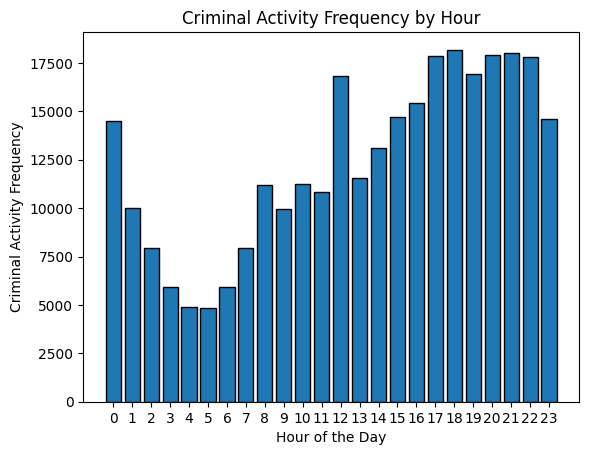

In [22]:
freq_ser = crime_df.groupby(crime_df['activitydate'].dt.hour).size()

plt.bar(x=freq_ser.index, height=freq_ser.values, edgecolor='black')
plt.title('Criminal Activity Frequency by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Criminal Activity Frequency')
plt.xticks(freq_ser.index)

We may notice that the frequency of criminal activity changes in a day, observing that high rates of criminal activity in the afternoon through evening hours, with crime rates dropping during the night. Thus, we create an `afternoon_till_eve` column by defining `activitydate` happened in the afternoon through evening hours(12:00am-12:00pm) as 1, other wise as 0.

In [23]:
hours = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]
crime_df['afternoon_till_eve'] = crime_df['activitydate'].dt.hour.isin(hours)
crime_df['afternoon_till_eve'] = crime_df['afternoon_till_eve'].astype(int)

3. select columns

**select `afternoon_till_eve` as confounding variable**
* activitydate: the specific report time
* bi_frequency: happened in high frequency time or low frequency time
* violationtype: violent or property

* sex: female or male
* age: young or old

In [24]:
sub_crime = crime_df[['activitydate', 'afternoon_till_eve', 'violationtype', 'crimecategory', 'zipcode', 'city']]

In [25]:
sub_crime

,activitydate,afternoon_till_eve,violationtype,crimecategory,zipcode,city
0,2016-01-01 00:00:00,1,VC,Vehicle Theft,91950,NATIONAL CITY
1,2016-01-01 00:00:00,1,PC,Non Res Burglary,92109,SAN DIEGO
2,2016-01-01 00:00:00,1,PC,Larceny < $400,92115,SAN DIEGO
3,2016-01-01 00:00:00,1,PC,Larceny >= $400,92109,SAN DIEGO
5,2016-01-01 00:00:00,1,PC,Larceny >= $400,92126,SAN DIEGO
...,...,...,...,...,...,...
312084,2020-07-31 23:00:00,1,VC,Vehicle Theft,91945,LEMON GROVE
312085,2020-07-31 23:00:00,1,VC,Vehicle Theft,92114,SAN DIEGO
312086,2020-07-31 23:00:00,1,VC,Vehicle Theft,92108,SAN DIEGO
312087,2020-07-31 23:23:00,1,PC,Aggravated Assault,92028,FALLBROOK


4. Aggregate based on `city` and `afternoon_till_eve`

In [26]:
ncrime = (sub_crime.groupby(['city', 'afternoon_till_eve'])
          ['activitydate']
          .count()
          .to_frame()
          .reset_index()
          .rename(columns={'activitydate': 'crime_count'}))
ncrime

,city,afternoon_till_eve,crime_count
0,4S RANCH,0,186
1,4S RANCH,1,481
2,ALPINE,0,371
3,ALPINE,1,855
4,BONITA,0,276
...,...,...,...
117,VISTA,1,5787
118,VISTA,0,324
119,VISTA,1,819
120,WARNER SPRINGS,0,21


5. Merge license data with crime data

In [27]:
df_license = nlicense.to_frame(name='license_count')

# merge with inner join
merged_df = pd.merge(df_license, ncrime, left_index=True, right_on='city', how='inner').reset_index(drop = True)
merged_df = merged_df[['city', 'license_count', 'crime_count', 'afternoon_till_eve']]
merged_df 

,city,license_count,crime_count,afternoon_till_eve
0,SAN DIEGO,769,48990,0
1,SAN DIEGO,769,106319,1
2,CHULA VISTA,70,6266,0
3,CHULA VISTA,70,16423,1
4,CARLSBAD,62,1590,0
...,...,...,...,...
73,CAMPO,1,147,1
74,JULIAN,1,59,0
75,JULIAN,1,128,1
76,DULZURA,1,28,0


6. Get density per capita data

In order to calculate the alcohol density per capita, and criminal activity density per capita, we access the population data from the following source:
https://data.census.gov/table/DECENNIALPL2020.P1?g=160XX00US0611194,0613392,0616378,0618506,0621712,0622678,0622804,0636294,0640004,0650398,0653322,0658520,0666000,0668196,0670224,0672506,0682996_8610000US92093_880XX00US9203706073&tp=true

In [28]:
cities = [
    'CARLSBAD',
    'CHULA VISTA',
    'CORONADO',
    'DEL MAR',
    'EL CAJON',
    'ENCINITAS',
    'ESCONDIDO',
    'IMPERIAL BEACH',
#     'LA JOLLA',
    'LA MESA',
    'NATIONAL CITY',
    'OCEANSIDE',
    'POWAY',
    'SAN DIEGO',
    'SAN MARCOS',
    'SANTEE',
    'SOLANA BEACH',
    'VISTA'
]

In [29]:
pop = pd.read_csv("population.csv")
population = pop.dropna().reset_index(drop=True)
population['Total:'] = population['Total:'].str.replace(',', '').astype(int)
population.rename(columns={'Label (Grouping)': 'city', 'Total:': 'population'}, inplace=True)
population['city'] = cities

population.head()

,city,population
0,CARLSBAD,114746
1,CHULA VISTA,275487
2,CORONADO,20192
3,DEL MAR,3954
4,EL CAJON,106215


7. Merge together to get finalized dataframe

In [30]:
merged_df = pd.merge(merged_df, population, on='city')

In [31]:
merged_df['alcohol_density'] = merged_df['license_count'] / merged_df['population']
merged_df['crime_density'] = merged_df['crime_count'] / merged_df['population']

In [32]:
merged_df

,city,license_count,crime_count,afternoon_till_eve,population,alcohol_density,crime_density
0,SAN DIEGO,769,48990,0,1386932,0.000554,0.035323
1,SAN DIEGO,769,106319,1,1386932,0.000554,0.076658
2,CHULA VISTA,70,6266,0,275487,0.000254,0.022745
3,CHULA VISTA,70,16423,1,275487,0.000254,0.059614
4,CARLSBAD,62,1590,0,114746,0.000540,0.013857
5,CARLSBAD,62,4117,1,114746,0.000540,0.035879
6,OCEANSIDE,61,3546,0,174068,0.000350,0.020371
7,OCEANSIDE,61,8498,1,174068,0.000350,0.048820
8,ESCONDIDO,55,1805,0,151038,0.000364,0.011951
9,ESCONDIDO,55,4375,1,151038,0.000364,0.028966


In [33]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                34 non-null     object 
 1   license_count       34 non-null     int64  
 2   crime_count         34 non-null     int64  
 3   afternoon_till_eve  34 non-null     int64  
 4   population          34 non-null     int64  
 5   alcohol_density     34 non-null     float64
 6   crime_density       34 non-null     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 2.0+ KB


## EDA

**Univariate Analysis**

In the univariate analysis, we would analyze the distribution of alcohol_density and the distribution of crime_density separately.

Firstly, let's check the descriptive statistics of two variables.

In [34]:
merged_df.describe()

,license_count,crime_count,afternoon_till_eve,population,alcohol_density,crime_density
count,34.000000,34.000000,34.000000,3.400000e+01,34.000000,34.000000
mean,78.823529,7281.411765,0.500000,1.619472e+05,0.000764,0.038500
std,176.049661,19443.344690,0.507519,3.179335e+05,0.000892,0.026706
min,7.000000,102.000000,0.000000,3.954000e+03,0.000254,0.005052
25%,21.000000,1183.750000,0.000000,4.884100e+04,0.000348,0.020103
50%,38.000000,1975.500000,0.500000,6.200700e+04,0.000395,0.030806
75%,55.000000,4013.750000,1.000000,1.147460e+05,0.000613,0.051875
max,769.000000,106319.000000,1.000000,1.386932e+06,0.003794,0.142135


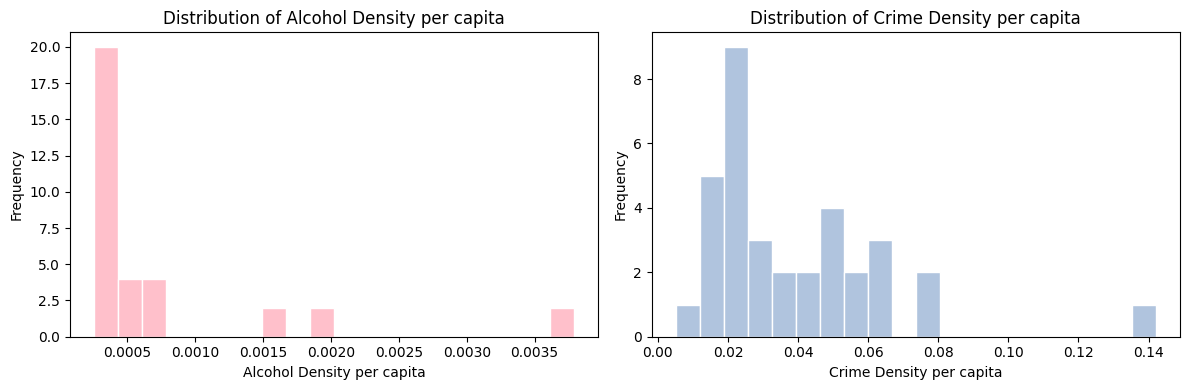

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

merged_df['alcohol_density'].plot(kind='hist', bins=20, ax=axs[0], color='pink', edgecolor='white')
axs[0].set_title('Distribution of Alcohol Density per capita')
axs[0].set_xlabel('Alcohol Density per capita')

merged_df['crime_density'].plot(kind='hist', bins=20, ax=axs[1], color='lightsteelblue', edgecolor='white')
axs[1].set_title('Distribution of Crime Density per capita')
axs[1].set_xlabel('Crime Density per capita')

plt.tight_layout()
plt.show()

**Bivariate Analysis**

explore relationship between alcohol_density and crime_density

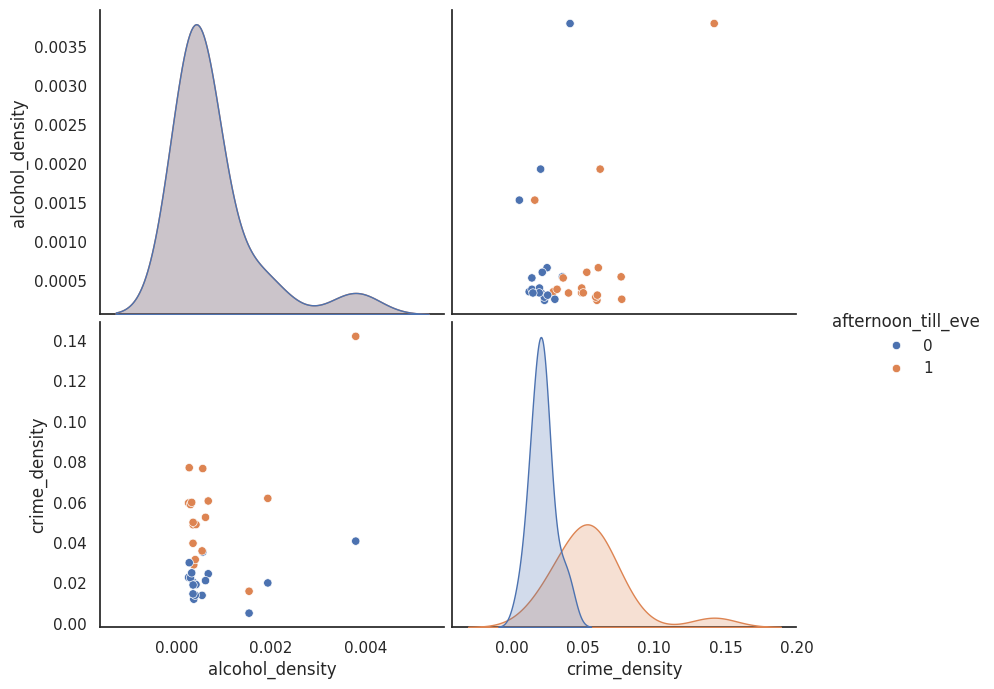

In [36]:
sns.set(style="white")
sns.pairplot(merged_df[['alcohol_density', 'crime_density', 'afternoon_till_eve']], hue = 'afternoon_till_eve', kind = 'scatter', height=3.5, aspect=1.2)

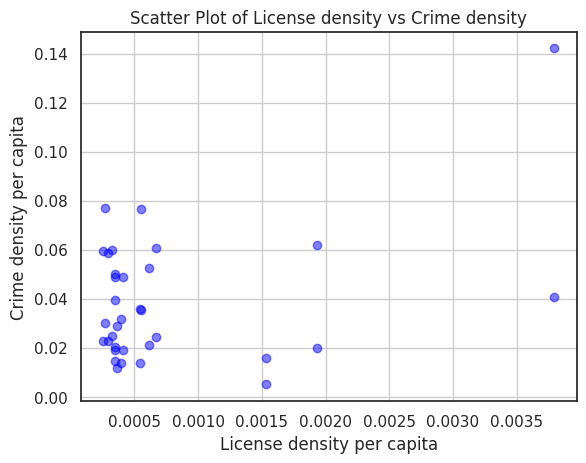

In [37]:
plt.scatter(merged_df['alcohol_density'], merged_df['crime_density'], color='blue', alpha=0.5)
plt.xlabel('License density per capita')
plt.ylabel('Crime density per capita')
plt.title('Scatter Plot of License density vs Crime density')
plt.grid(True)
plt.show()

## OLS

### model

In [38]:
full_model = smf.ols('crime_density ~ alcohol_density + afternoon_till_eve', data=merged_df).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:          crime_density   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     21.64
Date:                Thu, 30 May 2024   Prob (F-statistic):           1.31e-06
Time:                        23:13:49   Log-Likelihood:                 90.295
No. Observations:                  34   AIC:                            -174.6
Df Residuals:                      31   BIC:                            -170.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0123      0

### Diagnostics: check OLS assumptions

1. Linearity

Since residual plots does not show random scattering around zero for different values of the independent variables, thus the linearity assumption seems been violated.

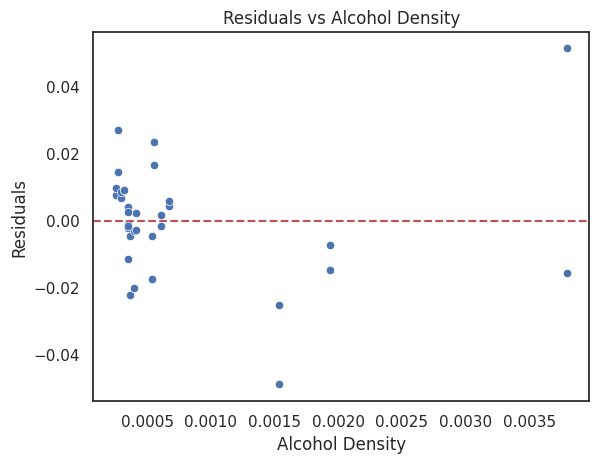

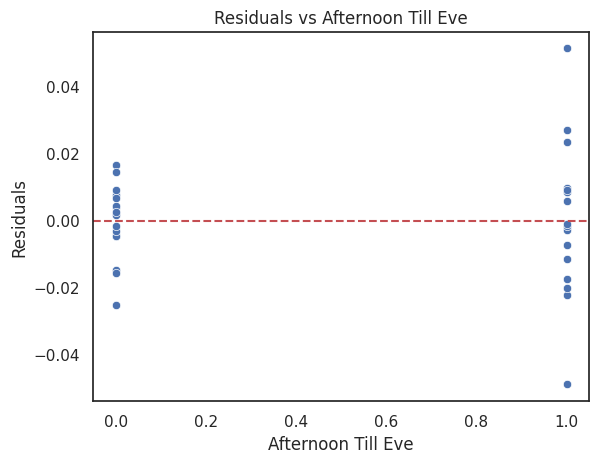

In [39]:
merged_df['residuals'] = full_model.resid

# Plot residuals against 'alcohol_density'
sns.scatterplot(data=merged_df, x='alcohol_density', y='residuals')
plt.title('Residuals vs Alcohol Density')
plt.xlabel('Alcohol Density')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--') 
plt.show()

# Plot residuals against 'afternoon_till_eve'
sns.scatterplot(data=merged_df, x='afternoon_till_eve', y='residuals')
plt.title('Residuals vs Afternoon Till Eve')
plt.xlabel('Afternoon Till Eve')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

2. **Normality** <br>

This Q-Q plot with points closely following the diagonal line indicates that the data is likely normally distributed.

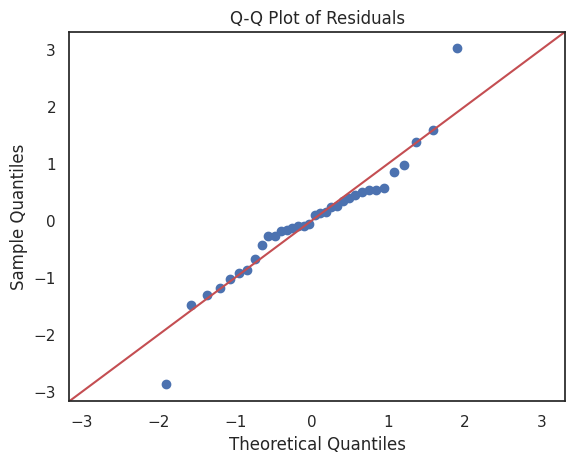

In [40]:
residuals = standardize(full_model.resid)
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

In [41]:
alpha = 0.15

shapiro = stats.shapiro(residuals)
print(f'Data: \t')
decision(shapiro.pvalue, alpha)

Data: 	
reject H0: pvalue=0.11467933654785156 < 0.15


3. **Heteroscedasticity** <br>

The identical assumption on the $\epsilon_i$ requires that the errors have constant variance. This can be checked by plotting the residuals against the predicted values of $y$. The residual plot shows some kind of pattern, indicating heteroscedasticity, **violating this assumption**.

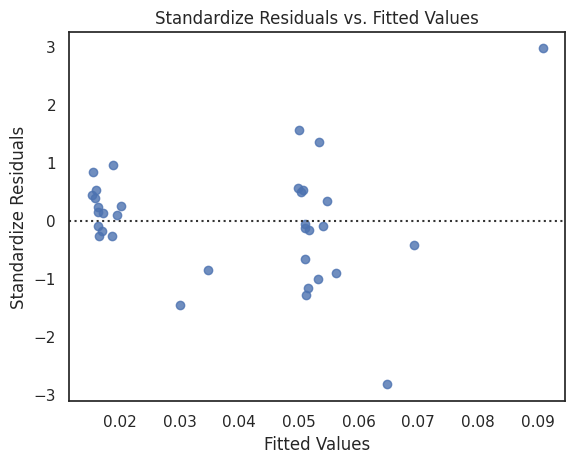

In [42]:
fitted_values = full_model.fittedvalues

sns.residplot(x=fitted_values, y=residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Standardize Residuals')
plt.title('Standardize Residuals vs. Fitted Values')
plt.show()

4. **Independence** <br>
The assumption of independence, which means that the residuals (errors) are independent of each other, appears to be violated. The Durbin-Watson statistic of 1.426 suggests some autocorrelation in the residuals, indicating that the independence assumption may not be fully satisfied. Ideally, the Durbin-Watson value should be close to 2 to indicate no autocorrelation.

The independence assumption on the $\epsilon_i$ requires that the errors are all independent. This can be checked by plotting the ACF functions for the residuals. We can see  one significant spike outside the confidence bands, this indicates autocorrelation and hence a potential **violation** of the independence assumption.

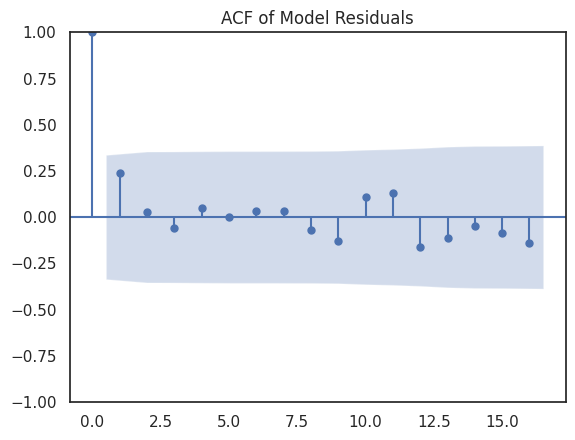

In [43]:
plot_acf(residuals)
plt.title('ACF of Model Residuals')
plt.show()

5. **Multicolinearity** <br>

The Variance Inflation Factor (VIF) is a measure used to detect multicollinearity in regression models. A VIF value greater than 10 is often considered indicative of high multicollinearity, which can affect the stability and interpretability of the regression coefficients.

`alcohol_density` and `afternoon_till_eve` have VIF values below 5. This indicates that these variables do not have severe multicollinearity issues.

In [44]:
exog = full_model.model.exog
names = full_model.params.index
for i in range(1, exog.shape[1]):
    print(f'VIF: {names[i]}: {variance_inflation_factor(exog, i): .3f}')

VIF: alcohol_density:  1.000
VIF: afternoon_till_eve:  1.000


In [46]:
# Step 1: Extract the list of cities from merged_data
cities = merged_df['city'].unique()

# Step 2: Filter sub_crime and sub_alcohol to include only rows where the city is in the list of cities from merged_data
filtered_crime = sub_crime[sub_crime['city'].isin(cities)]
filtered_alcohol = sub_alcohol[sub_alcohol['Prem City'].isin(cities)]

# Step 3: Convert zip codes to integers
filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)

# Step 4: Extract unique zip codes and their corresponding cities from the filtered dataframes
unique_crime_zipcodes = filtered_crime[['zipcode', 'city']].drop_duplicates()
unique_alcohol_zipcodes = filtered_alcohol[['Prem Zip', 'Prem City']].drop_duplicates()

# Step 5: Rename columns to have consistent names for merging
unique_alcohol_zipcodes = unique_alcohol_zipcodes.rename(columns={'Prem Zip': 'zipcode', 'Prem City': 'city'})

# Step 6: Combine the unique zip codes and their corresponding cities, and remove duplicates
all_unique_zipcodes = pd.concat([unique_crime_zipcodes, unique_alcohol_zipcodes]).drop_duplicates()


all_unique_zipcodes

/tmp/ipykernel_4158/778073358.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crime['zipcode'] = filtered_crime['zipcode'].astype(int)
/tmp/ipykernel_4158/778073358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_alcohol['Prem Zip'] = filtered_alcohol['Prem Zip'].astype(int)


,zipcode,city
0,91950,NATIONAL CITY
1,92109,SAN DIEGO
2,92115,SAN DIEGO
5,92126,SAN DIEGO
6,92037,SAN DIEGO
...,...,...
301587,92102,CHULA VISTA
305473,92023,CARLSBAD
68,92011,CARLSBAD
436,92081,VISTA
